# Setup

In [1]:
import random
import string
import os

from pylibdmtx.pylibdmtx import encode, decode
from PIL import Image

from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/module_pose/simple_synth', 'runs_dir': f'{root_dir}/yolo/runs'})
print(root_dir)

c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis


In [2]:
# Should print True if GPU is available for use
import torch
print(torch.cuda.is_available())

True


# Simple Synthesis

Synthesizing a simple DMC dataset for the ultralytics yolo11 pose model to use.

In [3]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''

    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))

    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode):
    '''Creates a PIL image containing DMC encoding of given string'''

    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels).convert('L')

    # crop image to remove white borders (have to leave some white border to do decode check)
    # img = img.crop((15, 15, img.width-15, img.height-15))

    # upscale image
    img = img.resize((640, 640), Image.NEAREST)

    return img

def get_pose_coords(img, debug=False):
    '''Returns the coordinates of each module within DMC info zone'''
    padding = 96      # padding around DMC info zone in pixels (we only want inner modules!)
    module_width = 32 # pixel width of each module

    raw_coords = [] # raw pixel centers of each module
    label_info = []

    # class info is always 0
    label_info.append(0)

    # center x y coords of entire image
    label_info.extend([0.5, 0.5])

    # width and height of entire DMC
    label_info.extend([0.8, 0.8])

    for x in range(padding+(module_width)//2, img.width-padding, module_width):
        for y in range(padding+(module_width)//2, img.height-padding, module_width):
            # Add raw pixel coords
            raw_coords.append((x, y))

            # Add class info to label_info

            # normalize pixel coords to 0-1
            x_norm = x / img.width
            y_norm = y / img.height
            if img.getpixel((x, y)) < 128:
                label_info.extend([x_norm, y_norm, 2]) # 2 for labeled and visible

                # paint pixel-to-check white for viz / debug
                if debug:
                    img.putpixel((x, y), (255))

            else:
                label_info.extend([x_norm, y_norm, 2]) # 1 for labeled but not visible (maybe try 0 for unlabeled (not in view))

                # paint pixel-to-check black for viz / debug
                if debug:
                    img.putpixel((x, y), (0))

    # convert to single string
    label_info = ' '.join([str(x) for x in label_info])

    # print(black_modules)
    # print(black_module_coords)
    # print(class_labels)
    return raw_coords, label_info

[(112, 112), (112, 144), (112, 176), (112, 208), (112, 240), (112, 272), (112, 304), (112, 336), (112, 368), (112, 400), (112, 432), (112, 464), (112, 496), (112, 528), (144, 112), (144, 144), (144, 176), (144, 208), (144, 240), (144, 272), (144, 304), (144, 336), (144, 368), (144, 400), (144, 432), (144, 464), (144, 496), (144, 528), (176, 112), (176, 144), (176, 176), (176, 208), (176, 240), (176, 272), (176, 304), (176, 336), (176, 368), (176, 400), (176, 432), (176, 464), (176, 496), (176, 528), (208, 112), (208, 144), (208, 176), (208, 208), (208, 240), (208, 272), (208, 304), (208, 336), (208, 368), (208, 400), (208, 432), (208, 464), (208, 496), (208, 528), (240, 112), (240, 144), (240, 176), (240, 208), (240, 240), (240, 272), (240, 304), (240, 336), (240, 368), (240, 400), (240, 432), (240, 464), (240, 496), (240, 528), (272, 112), (272, 144), (272, 176), (272, 208), (272, 240), (272, 272), (272, 304), (272, 336), (272, 368), (272, 400), (272, 432), (272, 464), (272, 496), (27

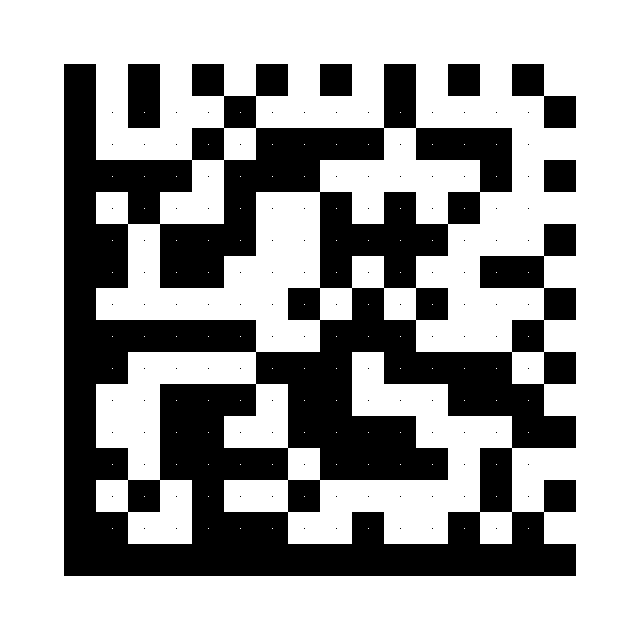

In [4]:
# testing
test = gen_string()
img = encode_image(test)
raw_coords, label_info = get_pose_coords(img, debug=True)
print(raw_coords)
print(label_info)
img

In [5]:
def gen_save(type):
    '''Generates a random serial number, encodes it into a DMC image, and saves it to train/val/test folders'''

    to_encode = gen_string()
    img = encode_image(to_encode)

    # save image
    img.save(f'../data/module_pose/simple_synth/images/{type}/{to_encode}.png')

    # get pose coordinates
    raw_coords, label_info = get_pose_coords(img)

    # save pose coordinates
    with open(f'../data/module_pose/simple_synth/labels/{type}/{to_encode}.txt', 'w') as f:
        f.write(f'{label_info}\n')

    return

def delete_old():
    '''Deletes all images and labels in train/val/test folders'''

    for folder in ['train', 'val', 'test']:
        for file in os.listdir(f'../data/module_pose/simple_synth/images/{folder}'):
            os.remove(f'../data/module_pose/simple_synth/images/{folder}/{file}')

        for file in os.listdir(f'../data/module_pose/simple_synth/labels/{folder}'):
            os.remove(f'../data/module_pose/simple_synth/labels/{folder}/{file}')
    
    # delete cache too (if it exists)
    if os.path.exists('../data/module_pose/simple_synth/labels/train.cache'):
        os.remove('../data/module_pose/simple_synth/labels/train.cache')
        os.remove('../data/module_pose/simple_synth/labels/val.cache')

    return

In [6]:
# delete old images and labels
delete_old()

In [7]:
# generating train/val/test datasets
n_train = 800
n_val = 100
n_test = 100

# train
for i in range(n_train - len(os.listdir('../data/module_pose/simple_synth/images/train'))):
    gen_save('train')

# val
for i in range(n_val - len(os.listdir('../data/module_pose/simple_synth/images/val'))):
    gen_save('val')

# test
for i in range(n_test - len(os.listdir('../data/module_pose/simple_synth/images/test'))):
    gen_save('test')

# Loading untrained model

In [8]:
model = YOLO('yolo11n-pose.yaml', task='pose')

# Training
Notes on trained models
- train: first model trained where white modules were labeled as 1 (labeled but not visible) and black modules 2 (labeled and visible)
- train2: first model trained where all modules were labeled as 2 (fixed no gpu)
- train3: same as above but with added pose=20 to see if it is the same as train2
- train4: same as above but with pose=40 to increase focus on pose estimation
- train5: same as above but with pose=100
- train6: same as above but with pose=40? train4 performed better than both train3 and train5
- train7: same as above but with pose=50
- train8: pose=30
- train9: pose=40 no patience (full 100 epochs)
- train10: pose=100 no patience
- train11: pose=40 no patience 1000 epochs

In [9]:
results = model.train(
    data=f'{root_dir}\\data\\module_pose\\simple_synth\\data.yml', # path to yaml file which specifies dataset parameters
    epochs=1000,
    imgsz=640,                                         # image size (default 640 for yolo)
    single_cls=True,                                   # single-class training
    patience=0,                                       # early stopping patience (after this many epochs with no improvement stop training)
    pretrained=False,                                  # don't use pre-trained weights
    plots=True,                                        # create plots

    # solving GPU memory issue?
    workers=0,                                         # number of worker threads for data loading (0 reduces memory problems at cost of slower training)
    batch=8,                                           # batch size (default 16, reducing to 8 can help)

    pose=40,                                           # Pose weight (default 20, increase to improve pose accuracy)
)

Ultralytics 8.3.75  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)
engine\trainer: task=pose, mode=train, model=yolo11n-pose.yaml, data=c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\module_pose\simple_synth\data.yml, epochs=1000, time=None, patience=0, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train11, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\module_pose\simple_synth\labels\train... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:01<00:00, 403.12it/s]


train: New cache created: C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\module_pose\simple_synth\labels\train.cache
WARNING  No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'


val: Scanning C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\module_pose\simple_synth\labels\val... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 379.44it/s]

val: New cache created: C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\data\module_pose\simple_synth\labels\val.cache


Plotting labels to c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\yolo\runs\pose\train11\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\yolo\runs\pose\train11
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      2.45G      2.979      39.51     0.7227      3.322      4.275         26        640: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        100        100    0.00333          1     0.0166      0.011          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      2.45G      2.964       39.7     0.7196      3.271      4.219         26        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        100        100     0.0156       0.59     0.0146    0.00432          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      2.51G      2.953      39.61     0.7152       3.19      4.129         16        640: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        100        100    0.00333          1     0.0165    0.00635          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      2.51G      2.886      39.49     0.7011      2.906      3.815         22        640: 100%|██████████| 100/100 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        100        100      0.156       0.46      0.162     0.0383          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      2.51G      2.693      39.68     0.6689      2.554      3.417         26        640: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        100        100    0.00297       0.89    0.00327    0.00035          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      2.51G      2.347      39.57     0.6253      2.123      3.047         16        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        100        100     0.0135       0.72     0.0138    0.00275          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      2.49G      1.897      39.64     0.5903      1.605      2.639         25        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        100        100      0.599       0.71      0.613      0.303          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      2.47G      1.517      39.73     0.5543      1.181      2.265         26        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        100      0.999          1      0.995      0.806          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      2.45G      1.237      39.62     0.5365     0.9459      2.003         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        100        100      0.999          1      0.995      0.803          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      2.45G     0.9926      39.71     0.5269     0.7853      1.784         12        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        100        100      0.999          1      0.995      0.896          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      2.43G     0.8889      39.53     0.5115     0.6949      1.638         21        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        100        100      0.999          1      0.995      0.898          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      2.44G     0.7827      39.32     0.4941     0.6316      1.512         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      2.45G     0.6937      39.86     0.4845     0.5774      1.413         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      2.43G     0.6104      39.69     0.4812     0.5198      1.329         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      2.43G     0.5724      39.68     0.4787     0.4914       1.27         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      2.43G     0.5436      39.63     0.4641     0.4643      1.226         21        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      2.42G     0.5103      39.74     0.4549     0.4511      1.187         20        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      2.43G     0.4725      39.54     0.4611     0.4247      1.146         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      2.43G      0.453      39.68     0.4469      0.411      1.136         23        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      2.43G     0.4325      39.58     0.4433     0.3948      1.104         20        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      2.43G     0.4138      39.57     0.4493     0.3854      1.085         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      2.43G     0.3983      39.65     0.4442     0.3741      1.069         16        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      2.43G      0.375      39.62     0.4399     0.3575       1.05         25        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      2.43G     0.3644      39.78       0.44     0.3508      1.043         19        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      2.43G     0.3561      39.67     0.4421     0.3428      1.034         23        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      2.43G     0.3405      39.71     0.4313     0.3356      1.019         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      2.43G     0.3264      39.71     0.4326     0.3237      1.004         20        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      2.43G     0.3286      39.71     0.4327     0.3179       1.01         19        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      2.44G     0.3126       39.7     0.4331     0.3073     0.9875         28        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      2.43G     0.3165      39.66     0.4297     0.3149     0.9872         23        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      2.43G     0.3048      39.62     0.4301     0.3085     0.9863         20        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      2.43G     0.2899      39.79     0.4366     0.3015     0.9854         26        640: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      2.43G     0.3034      39.46     0.4152     0.3013     0.9848         23        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      2.42G     0.2837      39.66     0.4158     0.2929     0.9765         20        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      2.44G     0.2781      39.54     0.4178     0.2903     0.9638         16        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      2.43G      0.275      39.73     0.4094     0.2854      0.964         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      2.43G      0.273      39.67     0.3994      0.283     0.9572         21        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      2.43G      0.273       39.6     0.3839     0.2788     0.9601         19        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      2.43G     0.2637      39.52     0.3635     0.2778     0.9591         16        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      2.43G     0.2613      39.64     0.3513      0.277     0.9638         19        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      2.43G     0.2603      39.66     0.3375     0.2752      0.956         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      2.44G     0.2526      39.64     0.3238      0.273     0.9571         23        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      2.44G      0.242      39.66      0.324      0.267     0.9553         24        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      2.42G     0.2516      39.67     0.3073     0.2659       0.94         25        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      2.43G     0.2368      39.82     0.3097     0.2553      0.944         19        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      2.44G     0.2422      39.64     0.2906     0.2625     0.9429         19        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      2.43G     0.2404      39.68     0.2806     0.2647     0.9382         15        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      2.43G     0.2363      39.62     0.2826     0.2538     0.9399         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      2.43G     0.2334      39.51     0.2763     0.2506     0.9417         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      2.43G     0.2223      39.69     0.2649     0.2514     0.9385         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      2.43G     0.2223      39.78     0.2388     0.2498     0.9352         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      2.43G     0.2139      39.68     0.2278     0.2437     0.9323         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      2.43G     0.2139      39.72     0.2178     0.2433     0.9343         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      2.42G     0.2159      39.77     0.2048     0.2449     0.9297         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      2.43G     0.2098      39.75     0.2062     0.2374     0.9283         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    56/1000      2.43G     0.2088      39.52     0.1985     0.2413     0.9244         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    57/1000      2.43G     0.2046      39.85     0.1926     0.2368     0.9318         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    58/1000      2.43G     0.2087      39.62     0.1927     0.2374     0.9314         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    59/1000      2.44G     0.2032      39.69     0.1878      0.239     0.9266         15        640: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    60/1000      2.43G     0.2039      39.65     0.1879     0.2333     0.9236         21        640: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    61/1000      2.43G     0.2052      39.53     0.1835     0.2328     0.9224         19        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    62/1000      2.43G     0.2014      39.77     0.1689     0.2287     0.9175         21        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    63/1000      2.43G     0.2022      39.65     0.1705     0.2309      0.919         26        640: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    64/1000      2.43G     0.1959      39.65     0.1594     0.2284     0.9208         18        640: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    65/1000      2.44G      0.199       39.6     0.1533      0.226     0.9211         25        640: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    66/1000      2.43G     0.1925      39.69     0.1378     0.2287     0.9197         26        640: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    67/1000      2.43G      0.191      39.56     0.1364     0.2234     0.9214         27        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    68/1000      2.43G     0.1966      39.66     0.1231     0.2181     0.9174         13        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    69/1000      2.43G     0.1853      39.72     0.1266     0.2155     0.9192         26        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    70/1000      2.43G     0.1851      39.51     0.1271     0.2222      0.917         18        640: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    71/1000      2.43G     0.1811      39.65      0.117     0.2163     0.9122         25        640: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    72/1000      2.43G      0.184      39.76     0.1149      0.218     0.9207         22        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    73/1000      2.43G     0.1767      39.66      0.122     0.2148     0.9164         18        640: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    74/1000      2.43G     0.1814      39.64     0.1079     0.2142     0.9122         16        640: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    75/1000      2.44G     0.1841       39.6     0.1063     0.2233     0.9165         26        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    76/1000      2.42G      0.171      39.76     0.1086     0.2092     0.9137         18        640: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    77/1000      2.43G     0.1786      39.67     0.1055     0.2061     0.9198         21        640: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    78/1000      2.43G     0.1733      39.68     0.1072     0.2082     0.9152         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    79/1000      2.43G      0.171      39.72     0.1069     0.2128     0.9126         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    80/1000      2.43G     0.1723      39.71      0.105     0.2124     0.9147         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    81/1000      2.43G     0.1753      39.64    0.09898     0.2114     0.9164         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    82/1000      2.43G     0.1686      39.55    0.09822     0.2088      0.918         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    83/1000      2.43G     0.1588      39.67     0.1038     0.2028     0.9068         32        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    84/1000      2.43G     0.1658      39.71     0.0987     0.2046     0.9083         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    85/1000      2.43G     0.1653      39.72    0.09495     0.2032     0.9103         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    86/1000      2.42G     0.1662      39.72    0.09064     0.2024     0.9084         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    87/1000      2.43G       0.16      39.65    0.09196     0.1973     0.9093         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    88/1000      2.43G     0.1566      39.71    0.09405     0.2005     0.9105         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    89/1000      2.43G     0.1579      39.62    0.09447     0.1983     0.9061         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    90/1000      2.43G     0.1607      39.79    0.08588     0.2025     0.9052         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    91/1000      2.43G     0.1641      39.53    0.08753     0.1998     0.9037         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    92/1000      2.43G     0.1602      39.59    0.08662     0.1984     0.9078         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    93/1000      2.43G     0.1582      39.52    0.08508     0.1923     0.9015         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    94/1000      2.43G     0.1528      39.87    0.08666     0.1924     0.9034         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    95/1000      2.43G     0.1569      39.74    0.08309     0.1914      0.906         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    96/1000      2.43G     0.1521      39.68    0.08142     0.1913     0.9037         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    97/1000      2.43G     0.1501      39.67     0.0933     0.1921     0.9072         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    98/1000      2.43G     0.1534      39.51    0.08726      0.197      0.904         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    99/1000      2.43G      0.159      39.67    0.08364      0.194     0.9018         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   100/1000      2.42G     0.1506      39.76    0.08301     0.1872     0.9044         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   101/1000      2.43G     0.1525      39.66    0.07822     0.1897     0.9107         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   102/1000      2.43G      0.148      39.64    0.08473     0.1878     0.9023         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   103/1000      2.43G     0.1486      39.72     0.0781     0.1887      0.901         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   104/1000      2.43G     0.1534      39.61    0.07851     0.1942     0.9035         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   105/1000      2.43G     0.1496      39.53    0.08156     0.1922     0.8982         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   106/1000      2.43G     0.1478      39.66    0.08152     0.1855      0.905         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   107/1000      2.43G     0.1425      39.69    0.07776     0.1832      0.903         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   108/1000      2.43G     0.1476      39.64    0.07386     0.1888     0.9041         30        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   109/1000      2.43G     0.1413      39.73    0.07852     0.1825     0.9024         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   110/1000      2.43G     0.1472      39.58     0.0802     0.1932      0.901         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   111/1000      2.43G     0.1435      39.79    0.07681     0.1826     0.9027         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   112/1000      2.43G     0.1436      39.69    0.06995     0.1868     0.8945         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   113/1000      2.43G     0.1419      39.52    0.07782     0.1846     0.8985         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   114/1000      2.43G     0.1449      39.79    0.07209     0.1818     0.9025         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   115/1000      2.43G     0.1434      39.66    0.07388     0.1786     0.9027         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   116/1000      2.43G     0.1395      39.74    0.07796     0.1757     0.9014         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   117/1000      2.43G     0.1411      39.68    0.07608     0.1806     0.9039         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   118/1000      2.43G     0.1418       39.7    0.07244     0.1849     0.8956         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   119/1000      2.43G      0.139      39.73     0.0726     0.1767     0.9031         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   120/1000      2.44G     0.1389      39.75    0.07077     0.1811     0.8994         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   121/1000      2.43G     0.1374      39.68    0.07254     0.1816     0.9011         24        640: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   122/1000      2.43G     0.1359      39.67    0.07699     0.1758     0.8917         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   123/1000      2.43G     0.1421       39.5    0.06955      0.183     0.8991         29        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   124/1000      2.43G     0.1363      39.57    0.07133     0.1786     0.8972         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   125/1000      2.43G     0.1371      39.81      0.071     0.1742     0.9008         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   126/1000      2.43G     0.1349      39.69    0.06858      0.173      0.899         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   127/1000      2.43G     0.1301      39.79    0.07786     0.1738     0.9001         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   128/1000      2.43G     0.1303      39.73    0.06847     0.1709     0.8947         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   129/1000      2.43G     0.1284      39.57    0.07092     0.1683     0.9004         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   130/1000      2.43G     0.1311      39.82    0.06769     0.1679     0.8942         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   131/1000      2.43G     0.1328      39.76    0.07184     0.1724     0.8989         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   132/1000      2.42G     0.1346      39.71    0.06762     0.1745      0.899         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   133/1000      2.43G     0.1313      39.79    0.06683     0.1712     0.8912         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   134/1000      2.44G     0.1319      39.67    0.06872     0.1774     0.8942         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   135/1000      2.43G     0.1325      39.57    0.06934     0.1717     0.8924         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   136/1000      2.43G     0.1287      39.77    0.06594     0.1686      0.892         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   137/1000      2.43G     0.1335      39.64    0.06919     0.1711     0.8951         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   138/1000      2.43G     0.1295      39.62    0.07115     0.1718     0.8897         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   139/1000      2.43G     0.1291      39.73     0.0677     0.1705     0.8904         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   140/1000      2.44G     0.1257      39.76    0.07418     0.1685     0.8935         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   141/1000      2.44G     0.1322       39.6    0.06853     0.1719     0.8919         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   142/1000      2.43G     0.1318      39.73    0.06628     0.1723     0.8903         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   143/1000      2.44G     0.1237      39.77    0.06767     0.1712     0.8996         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   144/1000      2.43G     0.1296      39.66    0.06688     0.1682     0.8992         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   145/1000      2.44G     0.1278      39.67    0.06138     0.1687     0.8933         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   146/1000      2.43G     0.1291      39.63    0.05874     0.1632      0.891         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   147/1000      2.44G     0.1251      39.76    0.06084      0.162     0.8896         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   148/1000      2.43G     0.1239      39.64    0.05724     0.1613     0.8934         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   149/1000      2.43G     0.1241      39.72    0.06071     0.1614     0.8906         30        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   150/1000      2.43G     0.1253       39.5     0.0621     0.1683     0.8909         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   151/1000      2.43G     0.1192      39.75    0.06406     0.1629     0.8901         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   152/1000      2.43G     0.1194      39.69    0.06243     0.1607     0.8911         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   153/1000      2.43G     0.1226      39.53    0.05712     0.1631     0.8948         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   154/1000      2.43G     0.1201      39.62    0.06228     0.1585      0.891         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   155/1000      2.44G     0.1195      39.65    0.05845     0.1603     0.8856         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   156/1000      2.43G     0.1199      39.69     0.0625     0.1607     0.8915         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   157/1000      2.43G     0.1269      39.62    0.05812     0.1651     0.8847         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   158/1000      2.43G     0.1254      39.64    0.05859     0.1607     0.8906         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   159/1000      2.43G     0.1236       39.6    0.05554     0.1655     0.8945         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   160/1000      2.43G     0.1208      39.78    0.05834     0.1583      0.894         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   161/1000      2.43G     0.1182      39.64    0.05912     0.1588      0.889         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   162/1000      2.42G     0.1147      39.64    0.06158     0.1569     0.8919         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   163/1000      2.44G     0.1169      39.68    0.06043     0.1543     0.8925         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   164/1000      2.43G     0.1212      39.64    0.05629     0.1625     0.8896         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   165/1000      2.43G     0.1166      39.72    0.05788      0.156     0.8916         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   166/1000      2.43G     0.1185      39.73    0.05571     0.1603     0.8914         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   167/1000      2.43G     0.1179       39.8    0.05724     0.1599     0.8905         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   168/1000      2.44G     0.1136       39.8    0.05411     0.1585     0.8884         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   169/1000      2.43G     0.1177      39.72    0.05517     0.1544     0.8933         13        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   170/1000      2.43G     0.1178      39.63     0.0559     0.1588      0.895         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   171/1000      2.42G      0.117      39.74     0.0586     0.1575      0.889         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   172/1000      2.43G     0.1186      39.85    0.05547     0.1584     0.8835         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   173/1000      2.44G     0.1167      39.67    0.05512      0.153     0.8901         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   174/1000      2.43G     0.1177       39.7    0.05143     0.1565     0.8922         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   175/1000      2.43G     0.1156      39.59    0.05477     0.1516     0.8897         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   176/1000      2.43G      0.112      39.71     0.0549     0.1519     0.8877         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   177/1000      2.44G     0.1129      39.67    0.05281     0.1522     0.8895         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   178/1000      2.43G     0.1173       39.7    0.04937     0.1503     0.8904         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   179/1000      2.43G     0.1102      39.72    0.05453     0.1471     0.8987         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   180/1000      2.43G     0.1105      39.78    0.05929      0.148      0.887         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   181/1000      2.43G     0.1111      39.63    0.05658      0.151     0.8855         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   182/1000      2.43G     0.1087      39.66    0.05272     0.1443     0.8889         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   183/1000      2.43G     0.1152      39.64    0.05557     0.1523     0.8902         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   184/1000      2.43G      0.111      39.71    0.05298     0.1505     0.8866         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   185/1000      2.43G     0.1095      39.77     0.0526     0.1499     0.8882         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   186/1000      2.43G     0.1092      39.74    0.05181     0.1469      0.885         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   187/1000      2.43G     0.1103      39.74    0.04895     0.1458     0.8874         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   188/1000      2.43G     0.1096      39.75    0.05627     0.1481     0.8873         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   189/1000      2.44G     0.1056       39.7     0.0579     0.1437      0.891         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   190/1000      2.43G     0.1108      39.62    0.05166     0.1534     0.8875         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   191/1000      2.44G     0.1102      39.56    0.05199      0.148     0.8898         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   192/1000      2.43G     0.1119       39.7    0.05486     0.1479     0.8907         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   193/1000      2.43G       0.11      39.66    0.04983     0.1484     0.8894         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   194/1000      2.43G      0.114      39.54    0.04929     0.1524     0.8879         22        640: 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   195/1000      2.42G     0.1104      39.67    0.04927     0.1521     0.8829         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   196/1000      2.43G     0.1112      39.62    0.05095     0.1463     0.8835         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   197/1000      2.43G     0.1094       39.6    0.05334     0.1506     0.8874         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   198/1000      2.43G     0.1099      39.58    0.04907     0.1485     0.8851         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   199/1000      2.43G     0.1095      39.64    0.04926     0.1484     0.8874         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   200/1000      2.43G       0.11      39.59    0.04902     0.1508     0.8902         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   201/1000      2.42G     0.1058      39.76    0.05538     0.1479     0.8885         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   202/1000      2.43G     0.1043      39.73    0.05377     0.1462     0.8868         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   203/1000      2.43G       0.11      39.72    0.05154     0.1499     0.8915         19        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   204/1000      2.43G     0.1063      39.65    0.04777      0.143     0.8875         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   205/1000      2.43G     0.1053      39.67    0.04702     0.1467     0.8861         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   206/1000      2.43G     0.1072      39.66    0.04801     0.1434     0.8841         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   207/1000      2.43G     0.1066      39.61    0.04794     0.1446     0.8878         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   208/1000      2.43G     0.1003      39.66    0.05324       0.14     0.8909         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   209/1000      2.43G     0.1053      39.49    0.04991     0.1478     0.8819         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   210/1000      2.43G     0.1054      39.65    0.04999     0.1476     0.8834         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   211/1000      2.43G     0.1048      39.54    0.05185     0.1445     0.8842         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   212/1000      2.43G     0.1025      39.69    0.05524     0.1397     0.8854         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   213/1000      2.43G     0.1061      39.68    0.04926     0.1425     0.8855         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   214/1000      2.43G     0.1071      39.66    0.04814     0.1466     0.8818         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   215/1000      2.44G     0.1035      39.79    0.05176     0.1439     0.8879         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   216/1000      2.43G     0.1052      39.64    0.04493     0.1472     0.8899         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   217/1000      2.43G     0.1053      39.69    0.04634     0.1447     0.8845         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   218/1000      2.43G     0.1003      39.77    0.05101     0.1416     0.8836         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   219/1000      2.43G     0.1028      39.55    0.04799     0.1395     0.8839         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   220/1000      2.43G     0.1007      39.78    0.04524     0.1405      0.886         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   221/1000      2.43G     0.1025      39.66    0.04698     0.1445     0.8882         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   222/1000      2.44G     0.1014      39.76    0.04356     0.1412     0.8872         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   223/1000      2.42G    0.09933      39.64    0.04791     0.1412     0.8875         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   224/1000      2.43G     0.1045      39.48     0.0447     0.1419     0.8822         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   225/1000      2.43G     0.1006      39.52    0.04897     0.1417     0.8864         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   226/1000      2.43G    0.09965      39.69    0.04943     0.1344     0.8813         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   227/1000      2.43G     0.1032      39.56    0.04748      0.137     0.8835         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   228/1000      2.43G     0.1011      39.76    0.04512     0.1434     0.8882         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   229/1000      2.43G        0.1      39.65    0.04767      0.155     0.8802         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   230/1000      2.43G     0.1029      39.49    0.04631     0.1408     0.8853         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   231/1000      2.43G    0.09922      39.66    0.04329     0.1353     0.8795         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   232/1000      2.44G    0.09742      39.61    0.04782     0.1368     0.8911         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   233/1000      2.43G     0.1024       39.6    0.04424     0.1432     0.8804         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   234/1000      2.42G    0.09581      39.74    0.04794     0.1356      0.881         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   235/1000      2.42G    0.09883      39.52    0.04607     0.1401     0.8806         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   236/1000      2.43G     0.1018      39.62    0.04535      0.139     0.8812         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   237/1000      2.43G    0.09778      39.78    0.04546     0.1374      0.882         26        640: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   238/1000      2.43G    0.09628      39.65    0.04784     0.1353     0.8873         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   239/1000      2.43G     0.1009      39.67    0.04281     0.1355     0.8856         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   240/1000      2.43G    0.09775      39.74    0.04409     0.1361     0.8837         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   241/1000      2.43G    0.09835      39.83     0.0444      0.133     0.8863         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   242/1000      2.43G     0.0951      39.61    0.04907     0.1379     0.8822         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   243/1000      2.43G    0.09742      39.66    0.04582     0.1379     0.8854         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   244/1000      2.43G    0.09676      39.66    0.04451     0.1366     0.8792         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   245/1000      2.43G    0.09477      39.68    0.04653     0.1358     0.8846         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   246/1000      2.44G    0.09572      39.62    0.04434     0.1328     0.8822         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   247/1000      2.43G     0.1009      39.58    0.04374      0.136      0.881         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   248/1000      2.43G    0.08987      39.81    0.04775     0.1296     0.8867         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   249/1000      2.43G    0.09517      39.68    0.04379     0.1314     0.8817         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   250/1000      2.44G    0.09461       39.6    0.04429     0.1358     0.8773         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   251/1000      2.43G    0.09521       39.7    0.04316     0.1308     0.8782         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   252/1000      2.43G    0.09254      39.64    0.04506     0.1336     0.8835         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   253/1000      2.43G    0.09359      39.71    0.04195     0.1351     0.8843         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   254/1000      2.42G    0.09322      39.72    0.04465     0.1301     0.8878         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   255/1000      2.43G    0.09349      39.69    0.04178     0.1341     0.8819         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   256/1000      2.43G    0.09329       39.8    0.04297     0.1298     0.8808         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   257/1000      2.43G    0.09319      39.71    0.04373     0.1341     0.8859         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   258/1000      2.44G    0.09167       39.7    0.04746     0.1311     0.8885         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   259/1000      2.42G    0.09192      39.74     0.0428     0.1302     0.8789         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   260/1000      2.43G    0.09266      39.66    0.04258      0.134     0.8826         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   261/1000      2.43G    0.08859      39.76    0.04377     0.1285     0.8815         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   262/1000      2.43G    0.08953      39.58    0.04766      0.128     0.8793         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   263/1000      2.44G    0.09644      39.52    0.04617     0.1378     0.8829         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   264/1000      2.43G    0.09411      39.61    0.04468     0.1341     0.8831         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   265/1000      2.43G    0.09568      39.64    0.04351      0.131     0.8859         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   266/1000      2.43G    0.09589       39.6    0.04423     0.1363     0.8868         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   267/1000      2.42G    0.09592      39.62    0.04343     0.1303     0.8802         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   268/1000      2.43G    0.09206      39.61    0.04449     0.1278     0.8789         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   269/1000      2.43G    0.09324      39.52    0.04423     0.1324     0.8823         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   270/1000      2.43G    0.09172      39.69    0.04175     0.1314     0.8795         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   271/1000      2.43G    0.09344      39.64    0.04306     0.1289     0.8824         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   272/1000      2.43G    0.08737      39.86    0.04353     0.1252     0.8785         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   273/1000      2.43G    0.09305      39.72    0.03917     0.1286     0.8773         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   274/1000      2.43G    0.09361      39.58    0.04143     0.1288     0.8744         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   275/1000      2.43G    0.08974      39.71    0.04311     0.1269     0.8806         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   276/1000      2.43G    0.08771      39.71    0.04135     0.1282     0.8802         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   277/1000      2.42G    0.09425      39.57    0.03894     0.1313     0.8794         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   278/1000      2.43G    0.08831      39.85    0.04065     0.1304     0.8795         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   279/1000      2.42G    0.08664      39.56     0.0453     0.1285     0.8757         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   280/1000      2.43G    0.09225      39.46    0.04296     0.1314     0.8795         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   281/1000      2.43G    0.08808      39.67    0.04203     0.1329     0.8863         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   282/1000      2.42G    0.08835      39.76    0.04458     0.1282     0.8882         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   283/1000      2.43G    0.08794      39.75    0.04036     0.1298     0.8835         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   284/1000      2.43G    0.09016      39.65    0.03866     0.1269     0.8808         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   285/1000      2.43G    0.09245      39.74    0.03867     0.1258     0.8748         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   286/1000      2.43G    0.08765      39.68    0.03909     0.1295     0.8749         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   287/1000      2.43G    0.08439      39.66    0.04729     0.1302     0.8774         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   288/1000      2.43G    0.08877      39.67    0.04093     0.1269     0.8793         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   289/1000      2.42G    0.08645      39.78    0.04146     0.1259     0.8824         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   290/1000      2.43G    0.08843      39.63    0.03942     0.1294     0.8786         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   291/1000      2.43G    0.08617      39.57    0.04276     0.1283     0.8803         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   292/1000      2.44G    0.08879      39.64    0.03832     0.1296     0.8834         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   293/1000      2.44G    0.08815      39.56    0.04139     0.1259     0.8843         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   294/1000      2.43G    0.08949      39.68    0.03674     0.1283      0.875         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   295/1000      2.43G    0.08715       39.7    0.03768     0.1266     0.8793         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   296/1000      2.44G    0.08813      39.72    0.04146     0.1274     0.8867         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   297/1000      2.43G    0.08722      39.64    0.03848     0.1262     0.8821         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   298/1000      2.43G      0.086      39.66    0.03885     0.1252      0.878         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   299/1000      2.43G    0.08848      39.67    0.04057     0.1231     0.8776         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   300/1000      2.43G    0.08672      39.54    0.04207     0.1229     0.8835         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   301/1000      2.43G    0.08627       39.5     0.0368     0.1276     0.8741         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   302/1000      2.43G    0.08513      39.63    0.03957     0.1236     0.8783         31        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   303/1000      2.43G    0.08476      39.64    0.04187     0.1218     0.8813         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   304/1000      2.43G    0.08478      39.67    0.03866     0.1215     0.8845         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   305/1000      2.43G    0.08436      39.75    0.03689     0.1185     0.8842         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   306/1000      2.43G    0.08623      39.65    0.03641     0.1266     0.8795         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   307/1000      2.44G    0.08785      39.69    0.03771     0.1276     0.8809         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   308/1000      2.43G    0.08726      39.52    0.03916     0.1285     0.8816         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   309/1000      2.43G    0.08271      39.59    0.04042     0.1195     0.8738         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   310/1000      2.43G    0.08289      39.57    0.04188     0.1221     0.8723         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   311/1000      2.43G    0.08259      39.65    0.04128     0.1235     0.8745         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   312/1000      2.43G    0.08426      39.68    0.03863     0.1231     0.8729         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   313/1000      2.43G    0.08594      39.67    0.03526     0.1243     0.8768         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   314/1000      2.43G    0.08443      39.69    0.03746     0.1174     0.8779         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   315/1000      2.43G    0.08527      39.66    0.03527     0.1173       0.88         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   316/1000      2.43G    0.08346      39.71    0.03709     0.1181     0.8815         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   317/1000      2.42G     0.0821      39.75    0.03646     0.1207      0.882         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   318/1000      2.43G    0.08412      39.57    0.04015      0.122     0.8808         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   319/1000      2.43G    0.08415      39.55    0.03552     0.1193     0.8783         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   320/1000      2.43G    0.08399      39.81    0.04011     0.1241     0.8797         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   321/1000      2.44G     0.0844      39.67    0.04023     0.1238     0.8761         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   322/1000      2.44G    0.08215      39.62    0.03755     0.1182     0.8829         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   323/1000      2.43G    0.08226      39.71    0.03603     0.1238     0.8763         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   324/1000      2.43G    0.08153      39.72    0.03739     0.1232     0.8757         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   325/1000      2.43G    0.08656      39.48    0.03443     0.1219     0.8763         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   326/1000      2.43G    0.08326      39.61    0.03699     0.1186      0.881         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   327/1000      2.43G    0.08216      39.43    0.03317     0.1243     0.8772         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   328/1000      2.43G    0.08385      39.48    0.03509     0.1211     0.8765         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   329/1000      2.44G    0.08371      39.64     0.0395     0.1191      0.872         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   330/1000      2.43G    0.07849      39.61    0.04223     0.1164     0.8832         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   331/1000      2.43G    0.08407      39.51    0.03578     0.1177     0.8745         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   332/1000      2.43G    0.08103      39.77    0.03744     0.1205     0.8848         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   333/1000      2.43G    0.08094      39.65    0.03871     0.1184     0.8741         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   334/1000      2.43G    0.08033      39.78    0.03722     0.1195     0.8794         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   335/1000      2.43G     0.0813      39.65    0.03391     0.1198     0.8796         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   336/1000      2.43G    0.07798      39.65    0.03397     0.1175     0.8793         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   337/1000      2.43G    0.08237      39.72    0.03349     0.1221     0.8768         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   338/1000      2.43G    0.08153      39.63    0.03537     0.1171     0.8779         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   339/1000      2.44G    0.07836      39.71    0.03721      0.114     0.8789         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   340/1000      2.43G    0.07886       39.6    0.03363     0.1184      0.871         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   341/1000      2.44G    0.07985      39.63    0.03342     0.1144     0.8762         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   342/1000      2.43G     0.0818      39.65    0.03815     0.1159     0.8757         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   343/1000      2.44G    0.08153      39.55    0.03499     0.1148      0.877         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   344/1000      2.43G    0.08017      39.52    0.03575     0.1171     0.8789         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   345/1000      2.44G    0.07954      39.56    0.03418     0.1211     0.8765         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   346/1000      2.43G    0.07747      39.71    0.03746     0.1145     0.8754         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   347/1000      2.44G      0.081      39.59    0.03384     0.1209     0.8733         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   348/1000      2.43G    0.07899      39.56    0.03618      0.117     0.8746         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   349/1000      2.43G    0.08137      39.76    0.03572     0.1164     0.8827         12        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   350/1000      2.43G    0.07915      39.73    0.03455     0.1178     0.8784         13        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   351/1000      2.43G     0.0778      39.57    0.03613     0.1131     0.8758         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   352/1000      2.44G    0.07707      39.73    0.03386     0.1171     0.8785         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   353/1000      2.43G    0.07383      39.75     0.0404     0.1101     0.8763         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   354/1000      2.43G    0.07628      39.85    0.03502       0.11     0.8787         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   355/1000      2.44G    0.07661      39.72    0.03483     0.1144     0.8793         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   356/1000      2.42G    0.07654      39.64    0.03676     0.1115      0.875         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   357/1000      2.43G    0.07848      39.58    0.03416     0.1162     0.8793         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   358/1000      2.43G    0.07977      39.59    0.03215     0.1171     0.8705         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   359/1000      2.43G    0.07849      39.58    0.03275     0.1171     0.8749         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   360/1000      2.42G    0.07909      39.68    0.03341     0.1225     0.8739         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   361/1000      2.43G    0.07891      39.71    0.03478     0.1135     0.8775         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   362/1000      2.43G    0.07643      39.66    0.03234     0.1137     0.8784         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   363/1000      2.43G    0.07924      39.57    0.03304     0.1169     0.8777         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   364/1000      2.43G    0.07497      39.59     0.0341     0.1182     0.8763         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   365/1000      2.43G    0.07708      39.62    0.03426     0.1132      0.877         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   366/1000      2.43G    0.07862      39.71    0.03143     0.1144     0.8774         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   367/1000      2.43G    0.07474       39.8    0.03112     0.1109     0.8707         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   368/1000      2.43G    0.07476      39.64    0.03375     0.1135     0.8782         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   369/1000      2.43G    0.07746      39.73    0.03128     0.1151       0.87         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   370/1000      2.42G    0.07671       39.7    0.03374     0.1133     0.8745         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   371/1000      2.43G    0.07768      39.49    0.03235     0.1159     0.8772         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   372/1000      2.43G     0.0764      39.64    0.03277     0.1174     0.8759         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   373/1000      2.43G    0.07554      39.72    0.03388     0.1092     0.8756         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   374/1000      2.42G    0.07474      39.72    0.03493     0.1146     0.8765         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   375/1000      2.42G    0.07703      39.69    0.03581     0.1142     0.8807         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   376/1000      2.43G    0.07792      39.66    0.03255     0.1136     0.8749         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   377/1000      2.42G    0.07828      39.38    0.03464     0.1129     0.8749         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   378/1000      2.43G    0.07814      39.64    0.03185      0.115     0.8773         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   379/1000      2.42G    0.07833      39.66    0.03204     0.1129     0.8784         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   380/1000      2.43G    0.07739      39.73    0.03297      0.115     0.8861         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   381/1000      2.43G    0.07661      39.66    0.03416      0.116     0.8812         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   382/1000      2.43G    0.07501      39.63    0.03194     0.1126     0.8723         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   383/1000      2.43G    0.07491      39.71    0.03174     0.1135     0.8714         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   384/1000      2.42G    0.07684      39.64    0.03109     0.1144     0.8765         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   385/1000      2.42G     0.0748      39.59    0.03239     0.1131     0.8754         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   386/1000      2.43G    0.07581      39.52    0.03185     0.1102     0.8745         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   387/1000      2.43G    0.07377      39.75    0.03417     0.1085     0.8786         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   388/1000      2.43G    0.07267      39.58     0.0353     0.1107     0.8771         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   389/1000      2.43G    0.07622      39.56    0.03466     0.1177     0.8757         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   390/1000      2.43G    0.07435      39.64    0.03303     0.1119     0.8827         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   391/1000      2.43G    0.07362      39.67    0.03343      0.111     0.8818         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   392/1000      2.43G    0.07783      39.63    0.03149     0.1112     0.8783         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   393/1000      2.44G    0.07676      39.58    0.03064     0.1123     0.8714         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   394/1000      2.43G    0.07475      39.66    0.03204     0.1115     0.8741         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   395/1000      2.43G     0.0739      39.69    0.03013     0.1128      0.879         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   396/1000      2.43G    0.07425      39.76    0.03105     0.1126     0.8728         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   397/1000      2.42G    0.07247      39.63    0.03526     0.1088     0.8786         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   398/1000      2.43G    0.07339      39.66    0.03216      0.111     0.8753         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   399/1000      2.43G    0.07097      39.68     0.0324     0.1123     0.8722         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   400/1000      2.43G     0.0731      39.66    0.03217      0.111     0.8761         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   401/1000      2.42G    0.07381      39.64    0.03047     0.1095     0.8769         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   402/1000      2.43G    0.07317      39.68    0.03129     0.1081     0.8779         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   403/1000      2.42G    0.07366      39.65    0.03122       0.11     0.8763         12        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   404/1000      2.43G    0.07152      39.52    0.03172     0.1071     0.8763         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   405/1000      2.43G    0.07022       39.7    0.03124      0.107     0.8775         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   406/1000      2.43G    0.07113      39.77    0.03238     0.1088     0.8736         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   407/1000      2.43G     0.0726      39.52    0.03373      0.109     0.8773         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   408/1000      2.43G    0.07338      39.72    0.02988     0.1157      0.878         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   409/1000      2.42G    0.07298      39.77    0.02983     0.1073     0.8812         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   410/1000      2.43G    0.07169      39.56      0.028     0.1056     0.8758         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   411/1000      2.43G    0.07103      39.69    0.02938     0.1096     0.8806         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   412/1000      2.43G    0.07139      39.74    0.02937     0.1124     0.8769         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   413/1000      2.43G    0.07032       39.7    0.03079     0.1046     0.8719         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   414/1000      2.43G    0.07338      39.69     0.0331     0.1094     0.8788         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   415/1000      2.43G    0.06988      39.75     0.0309     0.1121     0.8741         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   416/1000      2.42G    0.07169      39.69    0.03268     0.1097     0.8793         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   417/1000      2.43G     0.0701      39.63    0.03495     0.1029      0.873         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   418/1000      2.43G    0.07449      39.55     0.0326     0.1135     0.8815         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   419/1000      2.42G    0.07285      39.63    0.03243     0.1066     0.8741         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   420/1000      2.43G     0.0734      39.66     0.0295     0.1132     0.8747         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   421/1000      2.42G    0.07312      39.59    0.03532     0.1123     0.8773         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   422/1000      2.43G     0.0668      39.76    0.03272      0.108     0.8808         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   423/1000      2.43G    0.07013      39.66    0.03084     0.1065     0.8732         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   424/1000      2.43G    0.06801      39.63    0.02865      0.106     0.8729         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   425/1000      2.43G    0.07115      39.73    0.02957     0.1054     0.8709         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   426/1000      2.44G    0.07114      39.69    0.02917     0.1098     0.8817         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   427/1000      2.42G    0.07001      39.71    0.02914     0.1074     0.8825         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   428/1000      2.43G    0.07187      39.58    0.03015     0.1114     0.8748         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   429/1000      2.43G    0.07129      39.73    0.02892     0.1057     0.8721         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   430/1000      2.43G    0.07088      39.72    0.02778     0.1087     0.8708         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   431/1000      2.43G    0.07006      39.57    0.02694     0.1064     0.8813         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   432/1000      2.43G    0.06739      39.76    0.03459      0.104     0.8745         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   433/1000      2.43G    0.07025      39.75    0.03424     0.1033     0.8781         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   434/1000      2.43G    0.06925      39.65    0.03194     0.1059     0.8737         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   435/1000      2.42G    0.07055      39.53    0.02952     0.1079     0.8734         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   436/1000      2.43G    0.06798      39.66    0.02986     0.1069     0.8718         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   437/1000      2.43G    0.07003       39.5    0.02827     0.1079     0.8747         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   438/1000      2.43G    0.06898       39.6    0.02933     0.1067     0.8733         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   439/1000      2.43G    0.06889      39.57    0.03042     0.1048      0.877         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   440/1000      2.43G    0.07019      39.53    0.02781     0.1074      0.872         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   441/1000      2.42G    0.06965      39.61    0.03037     0.1064     0.8759         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   442/1000      2.43G    0.06818      39.75    0.02842     0.1033     0.8741         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   443/1000      2.43G    0.07076      39.64    0.02849     0.1079       0.87         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   444/1000      2.42G    0.07012      39.69    0.02961     0.1075     0.8806         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   445/1000      2.43G    0.06994      39.72    0.02869      0.105     0.8816         13        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100      0.999          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   446/1000      2.43G     0.0679      39.65    0.03172     0.1071     0.8805         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   447/1000      2.43G    0.06914      39.73    0.02954     0.1037     0.8739         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   448/1000      2.43G    0.06915      39.58    0.02978     0.1057     0.8727         30        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   449/1000      2.42G    0.06597      39.58    0.03132     0.1032     0.8747         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   450/1000      2.43G    0.06552      39.69    0.03138     0.1041     0.8794         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   451/1000      2.43G    0.06966       39.6    0.03202     0.1066     0.8734         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   452/1000      2.43G    0.07118      39.64    0.02849     0.1106     0.8784         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   453/1000      2.43G    0.06908      39.74    0.02932     0.1057     0.8765         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   454/1000      2.42G    0.06933       39.5     0.0319     0.1089     0.8782         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   455/1000      2.43G    0.06552      39.81    0.02928     0.1061     0.8827         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   456/1000      2.43G    0.06715      39.76     0.0307     0.1034     0.8748         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   457/1000      2.43G     0.0682      39.69    0.03303     0.1069     0.8704         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   458/1000      2.42G    0.06672      39.73    0.03304     0.1049     0.8706         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   459/1000      2.43G    0.06727      39.79    0.02932     0.1034     0.8801         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   460/1000      2.43G    0.06667       39.8    0.03159     0.1057     0.8765         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   461/1000      2.43G    0.06815      39.74    0.02698     0.1037     0.8763         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   462/1000      2.43G    0.06657      39.68    0.02848     0.1053     0.8755         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   463/1000      2.43G    0.06824      39.73    0.02759     0.1031     0.8713         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   464/1000      2.43G    0.06894      39.65    0.03042     0.1036     0.8769         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   465/1000      2.43G     0.0675      39.58    0.02941     0.1057     0.8726         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   466/1000      2.42G    0.06503      39.75    0.02767     0.1022     0.8707         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   467/1000      2.43G    0.06712       39.7    0.02773     0.1067     0.8685         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   468/1000      2.42G    0.06837      39.56     0.0282     0.1057     0.8673         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   469/1000      2.43G      0.067      39.59    0.02626      0.102     0.8767         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   470/1000      2.43G    0.06619       39.7    0.02613      0.104     0.8744         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   471/1000      2.42G    0.06837      39.71    0.02772     0.1017     0.8802         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   472/1000      2.42G     0.0667       39.7    0.02899     0.1036     0.8752         29        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   473/1000      2.43G    0.06521      39.84    0.02794     0.1035     0.8725         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   474/1000      2.43G    0.06728      39.72    0.02779     0.1093     0.8713         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   475/1000      2.43G    0.06746      39.69    0.02545     0.1033     0.8728         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   476/1000      2.43G    0.06778      39.78    0.02804     0.1061     0.8722         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   477/1000      2.43G    0.06603      39.68    0.02521     0.1009     0.8727         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   478/1000      2.42G    0.06336      39.73    0.02757      0.102     0.8712         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   479/1000      2.43G    0.06462      39.56     0.0287        0.1     0.8761         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   480/1000      2.42G    0.06627      39.68    0.02787     0.1028     0.8766         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   481/1000      2.43G    0.06579      39.67    0.02671     0.1048     0.8745         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   482/1000      2.43G    0.06558       39.7    0.02845     0.1025     0.8668         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   483/1000      2.43G    0.06464      39.66    0.02776     0.1032     0.8713         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   484/1000      2.43G    0.06456      39.79     0.0282    0.09896     0.8724         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   485/1000      2.42G     0.0655      39.55     0.0261     0.1022     0.8727         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   486/1000      2.43G    0.06319      39.85    0.02575    0.09927     0.8761         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   487/1000      2.43G    0.06469      39.69    0.02602      0.103     0.8736         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   488/1000      2.43G    0.06457      39.61    0.02824     0.1033     0.8731         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   489/1000      2.43G    0.06502      39.67    0.02442     0.1029     0.8749         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   490/1000      2.43G    0.06715      39.58    0.02428     0.1007     0.8761         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   491/1000      2.42G    0.06306      39.86    0.02375    0.09607     0.8722         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   492/1000      2.43G    0.06523      39.71    0.02438     0.1017     0.8728         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   493/1000      2.42G    0.06433      39.59    0.02427    0.09929     0.8707         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   494/1000      2.43G     0.0627      39.62    0.02676     0.1036     0.8741         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   495/1000      2.43G    0.06414       39.7    0.02595    0.09891     0.8742         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   496/1000      2.43G    0.05859      39.81    0.02507    0.09339     0.8719         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   497/1000      2.42G    0.06107      39.68    0.02896     0.1004     0.8671         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   498/1000      2.42G     0.0664      39.45    0.02525     0.1025     0.8693         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   499/1000      2.42G     0.0633      39.65    0.02625    0.09531     0.8758         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   500/1000      2.42G    0.06348       39.6     0.0298    0.09814     0.8768         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   501/1000      2.43G    0.06399      39.75    0.02741    0.09482     0.8737         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   502/1000      2.42G    0.06256      39.78    0.02691    0.09801     0.8708         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   503/1000      2.42G    0.06128      39.47    0.02502     0.1017      0.871         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   504/1000      2.43G    0.06334      39.58     0.0253    0.09525     0.8694         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   505/1000      2.43G    0.06087      39.72    0.02854    0.09412     0.8746         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   506/1000      2.43G    0.06098      39.69    0.02924    0.09667     0.8764         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   507/1000      2.42G     0.0618      39.71    0.02452     0.0972     0.8672         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   508/1000      2.43G     0.0615      39.72    0.02915    0.09688     0.8733         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   509/1000      2.43G    0.06166      39.64    0.02624    0.09937     0.8683         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   510/1000      2.43G    0.06027      39.71     0.0269    0.09996     0.8737         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   511/1000      2.42G    0.06031      39.72    0.02569    0.09801     0.8708         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   512/1000      2.42G    0.06264      39.74    0.02507     0.1017     0.8668         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   513/1000      2.42G    0.06167      39.72    0.02766     0.1013     0.8689         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   514/1000      2.43G    0.06211      39.69     0.0267    0.09987     0.8726         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   515/1000      2.42G    0.06045      39.83    0.02604    0.09777     0.8695         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   516/1000      2.43G    0.06398      39.65    0.02821     0.1019     0.8702         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   517/1000      2.43G    0.06511      39.36    0.02703      0.102     0.8717         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   518/1000      2.43G    0.06344      39.79    0.02583      0.099     0.8771         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   519/1000      2.43G    0.06361       39.5      0.027    0.09744     0.8707         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   520/1000      2.43G    0.06091      39.71    0.02739    0.09813     0.8735         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   521/1000      2.43G    0.06052      39.64    0.02576    0.09613     0.8675         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   522/1000      2.42G    0.06205      39.69    0.02434    0.09777     0.8735         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   523/1000      2.42G    0.06303      39.56    0.02409    0.09817     0.8703         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   524/1000      2.43G    0.06213      39.61    0.02583     0.1007     0.8717         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   525/1000      2.43G    0.06225      39.64    0.02468     0.0978     0.8699         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   526/1000      2.43G    0.06316      39.71     0.0244     0.1008      0.874         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   527/1000      2.43G    0.06145      39.65    0.02618    0.09681     0.8716         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   528/1000      2.43G    0.06028      39.55    0.02692    0.09467     0.8749         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   529/1000      2.43G     0.0605      39.64    0.02541    0.09405      0.872         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   530/1000      2.43G    0.05979      39.75    0.02449    0.09695     0.8658         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   531/1000      2.42G    0.05969      39.78    0.02789    0.09405     0.8732         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   532/1000      2.42G    0.06106      39.78    0.02551    0.09872     0.8666         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   533/1000      2.43G    0.06068      39.58     0.0243    0.09756     0.8738         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   534/1000      2.43G    0.06024      39.61    0.02525    0.09914     0.8716         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   535/1000      2.43G    0.06072      39.53    0.02444    0.09747     0.8736         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   536/1000      2.42G    0.06014      39.72    0.02441     0.1011     0.8754         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   537/1000      2.42G    0.06096      39.62    0.02588    0.09868      0.876         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   538/1000      2.43G    0.06093      39.59    0.02621    0.09653     0.8806         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   539/1000      2.43G    0.06142      39.71    0.02564     0.0972     0.8721         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   540/1000      2.43G    0.06051      39.63    0.02406    0.09675     0.8705         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   541/1000      2.42G    0.06061       39.8    0.02365    0.09702      0.865         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   542/1000      2.43G    0.05927      39.62    0.02321     0.1006     0.8749         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   543/1000      2.42G    0.05966      39.69    0.02554    0.09645      0.874         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   544/1000      2.43G    0.05775      39.72    0.02493    0.09547     0.8732         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   545/1000      2.43G    0.05685      39.71    0.02573    0.09134     0.8716         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   546/1000      2.43G    0.05802      39.65    0.02467    0.09326     0.8736         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   547/1000      2.43G    0.05928      39.49    0.02773      0.099     0.8674         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   548/1000      2.43G    0.05962      39.75    0.02422    0.09452     0.8724         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   549/1000      2.43G    0.05834      39.65     0.0232     0.0933     0.8828         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   550/1000      2.43G    0.05968       39.6    0.02275    0.09773     0.8741         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   551/1000      2.43G    0.05932      39.57    0.02372    0.09358     0.8696         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   552/1000      2.42G    0.05967      39.57    0.02373    0.09284     0.8701         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   553/1000      2.43G    0.05667      39.66    0.02535    0.09161     0.8798         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   554/1000      2.43G    0.05687      39.67    0.02849    0.09143     0.8706         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   555/1000      2.43G    0.06152      39.28    0.02682     0.1036     0.8791         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   556/1000      2.43G    0.06085       39.7    0.02314    0.09647     0.8708         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   557/1000      2.43G    0.05959      39.66    0.02299    0.09174     0.8706         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   558/1000      2.43G    0.05922      39.62    0.02334    0.09578     0.8704         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   559/1000      2.42G      0.058      39.79    0.02542    0.09312     0.8712         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   560/1000      2.42G    0.05909      39.51    0.02507    0.09556     0.8722         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   561/1000      2.44G     0.0583       39.7    0.02381    0.09317     0.8748         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   562/1000      2.43G    0.05887       39.6     0.0223    0.09029      0.869         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   563/1000      2.42G    0.05963      39.55    0.02462    0.09835     0.8694         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   564/1000      2.42G    0.05755      39.85    0.02163    0.09344     0.8723         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   565/1000      2.43G    0.05913      39.65    0.02266    0.09443     0.8741         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   566/1000      2.44G    0.05943      39.57    0.02342    0.09252     0.8783         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   567/1000      2.43G    0.05674      39.69     0.0227    0.09113     0.8734         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   568/1000      2.43G    0.05611      39.64    0.02805    0.09152     0.8755         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   569/1000      2.43G     0.0588      39.63    0.02571    0.09387     0.8736         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   570/1000      2.43G    0.06063      39.55    0.02358    0.09332     0.8696         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   571/1000      2.43G      0.058      39.64    0.02323    0.09443     0.8692         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   572/1000      2.43G    0.05732      39.64    0.02336    0.09207     0.8674         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   573/1000      2.42G    0.05899      39.62    0.02291     0.0941     0.8741         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   574/1000      2.42G    0.05672      39.67    0.02471    0.08965     0.8702         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   575/1000      2.42G    0.05825      39.77    0.02321    0.09209     0.8781         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   576/1000      2.43G    0.05747      39.81    0.02385    0.09308     0.8734         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   577/1000      2.43G    0.05853      39.66    0.02339     0.0972     0.8707         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   578/1000      2.42G    0.05804      39.76    0.02305    0.09093     0.8769         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   579/1000      2.42G    0.05625      39.68    0.02462    0.09011     0.8719         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   580/1000      2.43G    0.05654      39.54     0.0225    0.09297     0.8694         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   581/1000      2.43G    0.05817      39.56    0.02453    0.09339     0.8701         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   582/1000      2.43G    0.05683      39.68    0.02463    0.09087     0.8707         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   583/1000      2.43G    0.05634      39.75    0.02611    0.09305     0.8709         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   584/1000      2.43G    0.05591      39.75    0.02378    0.09317     0.8707         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   585/1000      2.43G    0.05764      39.68    0.02149    0.09568     0.8751         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   586/1000      2.42G    0.05586      39.67    0.02213    0.09355     0.8701         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   587/1000      2.42G    0.05531      39.63    0.02038    0.09304     0.8664         20        640: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   588/1000      2.43G    0.05631      39.63    0.02258    0.09019     0.8702         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   589/1000      2.43G    0.05706      39.68    0.02741    0.09174     0.8739         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   590/1000      2.42G    0.05586      39.67      0.025    0.09274     0.8721         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   591/1000      2.43G     0.0577      39.52    0.02229    0.09272     0.8736         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   592/1000      2.43G    0.05463      39.69    0.02274    0.08965     0.8711         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   593/1000      2.43G    0.05844      39.44    0.02192    0.09197     0.8751         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   594/1000      2.43G    0.05405      39.78    0.02338    0.09298     0.8695         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   595/1000      2.43G    0.05729       39.5    0.02448     0.0963     0.8671         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   596/1000      2.43G    0.05404      39.71    0.02408    0.09215     0.8757         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   597/1000      2.43G    0.05359      39.73    0.02192    0.08666     0.8703         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   598/1000      2.43G    0.05582      39.58    0.02469    0.08804     0.8739         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   599/1000      2.43G    0.05508      39.66    0.02225    0.08988     0.8777         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   600/1000      2.43G    0.05348      39.73    0.02121    0.08597     0.8722         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   601/1000      2.42G    0.05445      39.68    0.02082     0.0871     0.8699         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   602/1000      2.43G    0.05432      39.67    0.02203    0.08611     0.8731         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   603/1000      2.43G    0.05379      39.77    0.02057     0.0918     0.8698         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   604/1000      2.43G    0.05569      39.63    0.02063    0.09045     0.8693         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   605/1000      2.43G    0.05125      39.76    0.02228    0.08608     0.8751         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   606/1000      2.43G    0.05506      39.66    0.01934    0.08854     0.8719         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   607/1000      2.43G    0.05382      39.72    0.02057    0.09111      0.868         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   608/1000      2.42G    0.05532      39.61    0.02225     0.0925     0.8702         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   609/1000      2.43G    0.05492      39.79    0.02334    0.09046     0.8739         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   610/1000      2.43G    0.05356      39.61    0.02361    0.08789     0.8698         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   611/1000      2.42G    0.05488      39.68    0.02137    0.08792     0.8724         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   612/1000      2.43G    0.05412      39.57    0.02144      0.089     0.8694         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   613/1000      2.43G    0.05569      39.64    0.02028    0.09107      0.865         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   614/1000      2.43G    0.05487      39.61    0.02133    0.08959     0.8701         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   615/1000      2.43G    0.05357      39.67    0.02035    0.09457     0.8733         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   616/1000      2.42G    0.05352      39.45    0.02538    0.08814      0.875         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   617/1000      2.43G    0.05319      39.62    0.02282    0.08867      0.872         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   618/1000      2.44G    0.05388      39.57    0.02293    0.08743     0.8682         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   619/1000      2.42G    0.05389      39.46    0.02085    0.08512     0.8696         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   620/1000      2.43G    0.05215      39.78    0.02338    0.09083     0.8645         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   621/1000      2.43G    0.05199      39.62    0.02209    0.08468      0.869         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   622/1000      2.42G    0.05252      39.57    0.02006    0.08925     0.8685         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   623/1000      2.43G    0.05258      39.76    0.02112    0.08688     0.8732         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   624/1000      2.43G    0.05138      39.74    0.02051    0.08603     0.8732         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   625/1000      2.42G    0.05013      39.82    0.02095    0.08514     0.8728         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   626/1000      2.43G    0.05196      39.75    0.02131    0.08722     0.8688         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   627/1000      2.44G    0.05315      39.79    0.02022    0.08767     0.8683         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   628/1000      2.43G    0.05153      39.76    0.01957    0.08302     0.8737         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   629/1000      2.43G    0.05164      39.75    0.02123    0.08782     0.8716         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   630/1000      2.43G    0.05167      39.64    0.02036    0.08713     0.8717         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   631/1000      2.42G    0.04956      39.79    0.02129    0.08346     0.8724         14        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   632/1000      2.42G     0.0525      39.73    0.01974    0.08724     0.8709         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   633/1000      2.42G    0.05124      39.63    0.01964    0.08807      0.874         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   634/1000      2.43G    0.05175       39.7    0.02067    0.08955     0.8688         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   635/1000      2.43G    0.05371      39.67    0.02267    0.08779     0.8714         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   636/1000      2.43G    0.05224      39.64    0.01994    0.08636       0.87         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   637/1000      2.43G    0.05232      39.66     0.0205    0.08337     0.8732         29        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   638/1000      2.43G    0.05275       39.5    0.02022    0.08965     0.8667         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   639/1000      2.43G    0.05236      39.67    0.02138    0.08491     0.8685         30        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   640/1000      2.43G      0.052      39.52     0.0226    0.08943      0.871         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   641/1000      2.43G    0.05285      39.63    0.02167    0.08513     0.8731         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   642/1000      2.42G     0.0519      39.58    0.02243    0.08951     0.8713         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   643/1000      2.43G    0.05143      39.59    0.02102    0.09165     0.8742         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   644/1000      2.42G    0.05183       39.8    0.02141    0.08548     0.8729         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   645/1000      2.43G    0.05194      39.58    0.02191    0.08833     0.8691         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   646/1000      2.43G    0.05122      39.73     0.0201    0.08614     0.8652         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   647/1000      2.42G     0.0512      39.76    0.02119    0.08457     0.8706         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   648/1000      2.43G    0.05034      39.71    0.02112    0.09094     0.8686         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   649/1000      2.43G    0.05282      39.62    0.02002    0.08774     0.8661         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   650/1000      2.43G    0.05227      39.79    0.02016    0.08273     0.8656         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   651/1000      2.43G    0.05353      39.52    0.02056     0.0879     0.8765         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   652/1000      2.43G    0.05155      39.71    0.02162    0.08624     0.8704         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   653/1000      2.43G    0.05204      39.54    0.02068    0.08769     0.8746         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   654/1000      2.42G    0.05025      39.67    0.01882    0.08604     0.8671         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   655/1000      2.43G    0.05123      39.59    0.02103    0.08432     0.8737         29        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   656/1000      2.43G    0.05033      39.62     0.0199    0.08584     0.8619         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   657/1000      2.43G    0.05142      39.58    0.02007    0.08507      0.867         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   658/1000      2.43G    0.04961      39.73    0.01989    0.08561     0.8693         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   659/1000      2.42G    0.04925      39.73    0.01906    0.08389      0.871         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   660/1000      2.43G     0.0497      39.64    0.01997    0.08789     0.8702         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   661/1000      2.43G    0.04936      39.63    0.01981    0.08115     0.8673         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   662/1000      2.43G    0.05155      39.61    0.02106     0.0882     0.8668         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   663/1000      2.43G    0.04856      39.79    0.01991    0.08409     0.8648         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   664/1000      2.43G    0.04957      39.63    0.01891    0.08364     0.8621         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   665/1000      2.42G    0.04798      39.78    0.02054    0.08231     0.8715         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   666/1000      2.43G    0.05041      39.72    0.01978    0.08554       0.87         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   667/1000      2.43G    0.05066      39.66    0.02043    0.08337     0.8691         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   668/1000      2.43G    0.05045      39.75    0.02042    0.08565     0.8688         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   669/1000      2.42G    0.05077      39.65    0.01887    0.08118     0.8695         18        640: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   670/1000      2.43G    0.05092      39.81    0.01974    0.08489     0.8732         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   671/1000      2.43G    0.05007       39.8     0.0207    0.08309     0.8757         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   672/1000      2.43G    0.04897       39.7    0.02037    0.08836     0.8758         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   673/1000      2.42G    0.04949      39.57    0.01937    0.07963     0.8713         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   674/1000      2.43G    0.04797      39.84    0.01855    0.08007     0.8637         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   675/1000      2.43G    0.04936      39.71    0.01948    0.08449     0.8713         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   676/1000      2.43G    0.04867      39.81    0.01997    0.08828     0.8687         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   677/1000      2.42G    0.04896      39.76    0.01991    0.08595      0.868         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   678/1000      2.43G    0.05051      39.58    0.01954    0.08925     0.8701         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   679/1000      2.43G    0.04995       39.7    0.01797    0.08051     0.8696         29        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   680/1000      2.43G    0.04917      39.68    0.01953    0.08386     0.8633         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   681/1000      2.43G    0.05081      39.52    0.01951    0.08299     0.8733         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   682/1000      2.43G    0.04924       39.6     0.0189    0.08473     0.8705         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   683/1000      2.43G    0.04943      39.47    0.02175     0.0842     0.8661         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   684/1000      2.43G    0.05051      39.55    0.02066    0.08341      0.865         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   685/1000      2.43G    0.04769      39.62    0.01876    0.08206     0.8673         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   686/1000      2.43G    0.04878      39.67    0.01983    0.08737     0.8709         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   687/1000      2.43G    0.04816      39.67    0.01966    0.08343     0.8683         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   688/1000      2.43G    0.04721      39.72     0.0194    0.07752     0.8663         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   689/1000      2.43G    0.04801      39.71    0.01872    0.08194      0.868         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   690/1000      2.43G    0.04911      39.58    0.01867    0.08019     0.8691         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   691/1000      2.43G    0.04882      39.52    0.01872    0.08301     0.8663         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   692/1000      2.43G    0.04888      39.65    0.01931    0.08434     0.8698         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   693/1000      2.43G    0.04712      39.67    0.01892    0.07703     0.8703         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   694/1000      2.42G    0.04812      39.59    0.02173     0.0842     0.8706         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   695/1000      2.43G    0.04687      39.69    0.01929    0.07711     0.8708         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   696/1000      2.43G    0.04776       39.6    0.01783    0.07688     0.8701         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   697/1000      2.43G    0.04789      39.84    0.01752    0.07904     0.8669         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   698/1000      2.43G    0.04843      39.56    0.01807    0.07976     0.8657         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   699/1000      2.43G    0.04656      39.74    0.01828    0.08108     0.8725         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   700/1000      2.43G    0.04763      39.66    0.01913    0.08065     0.8753         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   701/1000      2.42G    0.04622      39.66     0.0218    0.07761     0.8661         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   702/1000      2.43G    0.04593      39.74    0.01725    0.07787      0.868         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   703/1000      2.43G    0.04787      39.65    0.01764    0.08076     0.8713         25        640: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   704/1000      2.43G    0.04673      39.74    0.01876    0.08052      0.868         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   705/1000      2.43G    0.04725      39.61    0.01936    0.08099     0.8752         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   706/1000      2.43G    0.04634       39.6    0.01876    0.08176      0.871         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   707/1000      2.43G    0.04509       39.7    0.01767    0.07794     0.8745         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   708/1000      2.42G    0.04636      39.66     0.0187    0.07755      0.865         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   709/1000      2.42G    0.04715      39.56    0.01816    0.07672     0.8708         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   710/1000      2.43G    0.04537      39.66    0.01824    0.07747     0.8729         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   711/1000      2.43G    0.04589      39.64    0.01837    0.07538     0.8681         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   712/1000      2.43G    0.04664       39.7    0.02065    0.07923     0.8655         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   713/1000      2.43G    0.04601      39.69     0.0184    0.07961     0.8698         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   714/1000      2.43G    0.04608      39.74    0.01796    0.07956     0.8701         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   715/1000      2.42G    0.04623      39.55    0.02002    0.08586     0.8691         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   716/1000      2.43G     0.0466      39.61    0.01782    0.07887     0.8644         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   717/1000      2.42G    0.04563      39.76    0.01799    0.08031      0.865         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   718/1000      2.43G    0.04492      39.75    0.01622    0.07991     0.8667         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   719/1000      2.43G    0.04511      39.71    0.02017    0.07962     0.8668         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   720/1000      2.43G    0.04722      39.69    0.01827     0.0808     0.8691         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   721/1000      2.42G      0.047      39.54    0.02041    0.07652      0.867         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   722/1000      2.42G    0.04661      39.61    0.01847    0.08025     0.8654         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   723/1000      2.42G    0.04378      39.66    0.02172    0.07893     0.8654         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   724/1000      2.43G    0.04509      39.58    0.01834    0.07753     0.8745         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   725/1000      2.42G    0.04543      39.73    0.01945    0.07959     0.8735         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   726/1000      2.43G     0.0453      39.64    0.01782    0.07964     0.8719         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   727/1000      2.43G    0.04359      39.71    0.01693    0.07644     0.8685         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   728/1000      2.43G    0.04427      39.61    0.01971    0.07498     0.8713         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   729/1000      2.43G    0.04405      39.76    0.01794    0.07895     0.8645         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   730/1000      2.43G    0.04447       39.7    0.01555     0.0769     0.8702         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   731/1000      2.42G    0.04361      39.68     0.0168    0.07297     0.8703         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   732/1000      2.43G    0.04655      39.79    0.01808    0.07615     0.8715         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   733/1000      2.43G    0.04619       39.7    0.01837    0.07816     0.8713         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   734/1000      2.43G    0.04516      39.71    0.01725    0.07614     0.8657         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   735/1000      2.43G    0.04668      39.58    0.01767    0.08114     0.8663         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   736/1000      2.43G    0.04468      39.78    0.01735    0.07765     0.8678         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   737/1000      2.43G    0.04456      39.53    0.01862    0.07992     0.8641         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   738/1000      2.44G    0.04595      39.64     0.0177    0.08919     0.8744         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   739/1000      2.44G    0.04462      39.66    0.01754    0.07561     0.8706         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   740/1000      2.43G    0.04625      39.77    0.01946    0.07769     0.8708         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   741/1000      2.43G    0.04454      39.79     0.0171    0.07589     0.8686         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   742/1000      2.43G    0.04581      39.44    0.01827    0.07958     0.8715         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   743/1000      2.43G    0.04341       39.6    0.02018    0.07391     0.8665         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   744/1000      2.42G    0.04468      39.56    0.01772    0.07912     0.8679         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   745/1000      2.42G    0.04257       39.8    0.01736     0.0744     0.8681         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   746/1000      2.43G    0.04331      39.62    0.01881    0.07506     0.8703         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   747/1000      2.43G     0.0454      39.64    0.02131    0.07763     0.8688         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   748/1000      2.43G    0.04318      39.75    0.01673    0.07718     0.8696         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   749/1000      2.43G    0.04363      39.65    0.02132    0.07384     0.8688         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   750/1000      2.43G    0.04479      39.64    0.01762    0.07681     0.8731         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   751/1000      2.43G    0.04579      39.66    0.01741    0.08054     0.8743         13        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   752/1000      2.42G    0.04487      39.76    0.01793    0.07605     0.8658         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   753/1000      2.43G    0.04644      39.76    0.01707    0.07823     0.8646         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   754/1000      2.43G    0.04428      39.56    0.01713    0.07641     0.8705         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   755/1000      2.42G    0.04301      39.63    0.01708    0.07739     0.8682         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   756/1000      2.42G    0.04302      39.53    0.01591    0.07417     0.8665         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   757/1000      2.42G    0.04381      39.72    0.01649    0.07534     0.8709         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   758/1000      2.43G    0.04267      39.56     0.0179    0.07678     0.8722         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   759/1000      2.43G    0.04249      39.64    0.01608    0.07481     0.8691         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   760/1000      2.42G    0.04362      39.73    0.01664    0.07977     0.8692         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   761/1000      2.43G    0.04305       39.7    0.01541    0.07676     0.8683         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   762/1000      2.42G    0.04296      39.79    0.01728    0.07412     0.8688         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   763/1000      2.43G    0.04239      39.69    0.01729    0.07406      0.866         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   764/1000      2.42G      0.042       39.7    0.01605    0.07505     0.8639         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   765/1000      2.42G    0.04386      39.58    0.01572    0.07792     0.8664         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   766/1000      2.43G    0.04175      39.62    0.01621    0.07607     0.8677         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   767/1000      2.43G    0.04348      39.55    0.01662    0.07727     0.8719         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   768/1000      2.42G    0.04193      39.57    0.01789     0.0748     0.8642         15        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   769/1000      2.42G    0.04044       39.8    0.01777    0.07355     0.8683         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   770/1000      2.43G    0.03992      39.76    0.01713    0.07275     0.8749         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   771/1000      2.43G    0.04028      39.55    0.01731     0.0716     0.8688         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   772/1000      2.43G    0.04113      39.62    0.01809    0.07357      0.871         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   773/1000      2.43G    0.04068      39.69    0.01624    0.07219     0.8714         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   774/1000      2.43G    0.03999      39.76    0.01629     0.0747     0.8689         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   775/1000      2.43G    0.04067      39.73    0.01561    0.07246       0.87         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   776/1000      2.44G    0.04156       39.8    0.01654    0.07702     0.8739         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   777/1000      2.43G    0.04247      39.63    0.01516    0.07743     0.8634         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   778/1000      2.44G    0.04019      39.73    0.01745    0.07709     0.8678         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   779/1000      2.43G    0.03992       39.7    0.01503    0.07298     0.8657         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   780/1000      2.43G    0.04098      39.66     0.0164    0.07166     0.8675         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   781/1000      2.43G    0.04157      39.72    0.01725    0.07179      0.868         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   782/1000      2.43G    0.03998      39.57    0.02312    0.07123     0.8708         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   783/1000      2.43G    0.04115      39.66    0.01678    0.07582     0.8659         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   784/1000      2.43G     0.0416      39.61    0.01709    0.07576     0.8702         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   785/1000      2.42G    0.03964      39.71    0.01612    0.07475     0.8687         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   786/1000      2.42G    0.03933      39.78    0.01617    0.07482     0.8657         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   787/1000      2.42G    0.03913      39.71    0.01535    0.06999     0.8659         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   788/1000      2.43G    0.03993      39.53    0.01576    0.07229     0.8685         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   789/1000      2.43G    0.04081      39.69    0.01537    0.07262     0.8695         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   790/1000      2.42G    0.04131      39.77     0.0159    0.07303     0.8739         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   791/1000      2.42G    0.03906      39.75    0.01456    0.07401     0.8657         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   792/1000      2.43G    0.03891      39.62    0.01648    0.06964     0.8678         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   793/1000      2.43G    0.03857       39.6    0.01596    0.07171     0.8644         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   794/1000      2.43G    0.03997      39.53    0.01729    0.07252     0.8679         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   795/1000      2.43G    0.04066      39.63    0.01531    0.07456     0.8697         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   796/1000      2.43G    0.04179      39.62    0.01694    0.07646     0.8745         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   797/1000      2.43G    0.03885      39.63    0.01591    0.07507     0.8672         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   798/1000      2.43G    0.04122       39.5    0.01511    0.07343     0.8716         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   799/1000      2.43G    0.04065      39.66    0.01581    0.07806     0.8692         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   800/1000      2.42G    0.03899      39.76    0.01726    0.07127     0.8697         24        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   801/1000      2.43G    0.03897      39.63    0.01641    0.07087     0.8696         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   802/1000      2.42G     0.0394      39.59    0.01694     0.0735      0.865         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   803/1000      2.43G    0.03823      39.74    0.01614    0.07264     0.8719         27        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   804/1000      2.43G    0.03925      39.75    0.01524    0.06697     0.8664         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   805/1000      2.43G    0.03786      39.76    0.01645    0.07114     0.8682         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   806/1000      2.43G    0.03749      39.64    0.01466    0.07057     0.8635         17        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   807/1000      2.43G    0.03854       39.8    0.01562    0.07198     0.8644         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   808/1000      2.43G    0.03997      39.59    0.01584    0.07446     0.8698         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   809/1000      2.42G    0.03752       39.7    0.01516    0.07163     0.8709         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   810/1000      2.43G    0.03814      39.66    0.01567    0.06921     0.8723         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   811/1000      2.42G     0.0377      39.64    0.01513    0.07136     0.8661         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   812/1000      2.43G    0.03926      39.76    0.01499    0.07298      0.864         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   813/1000      2.43G    0.03847      39.71    0.01619    0.07235     0.8659         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   814/1000      2.43G    0.03764      39.66    0.02037    0.06772     0.8647         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   815/1000      2.43G    0.03789      39.62    0.01558    0.06843     0.8744         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   816/1000      2.43G    0.03928      39.61    0.01461    0.07134     0.8639         16        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   817/1000      2.43G    0.03845      39.75    0.01562    0.07119     0.8645         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   818/1000      2.44G     0.0377      39.68    0.01691    0.07437     0.8602         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   819/1000      2.43G    0.03807      39.45    0.01477    0.06952     0.8657         21        640: 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   820/1000      2.43G    0.03801      39.67    0.01554    0.06818     0.8635         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   821/1000      2.43G    0.03775       39.6    0.01576    0.06837     0.8704         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   822/1000      2.42G    0.03697      39.67    0.01535    0.06472     0.8624         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   823/1000      2.43G    0.03674      39.77    0.01507    0.06714      0.868         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   824/1000      2.43G    0.03808      39.46    0.01553     0.0667     0.8672         20        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   825/1000      2.44G    0.03686      39.81     0.0147    0.07102     0.8669         18        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   826/1000      2.43G    0.03743      39.76    0.01468    0.06738     0.8617         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   827/1000      2.43G    0.03592      39.75    0.01499    0.06575      0.866         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   828/1000      2.43G     0.0368      39.57    0.01595    0.06703     0.8631         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   829/1000      2.43G    0.03727      39.66    0.01454    0.06737     0.8692         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   830/1000      2.43G    0.03748      39.54    0.01396    0.07546     0.8608         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   831/1000      2.43G    0.03728      39.68    0.01606     0.0693     0.8659         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   832/1000      2.42G    0.03727      39.71    0.01476     0.0702     0.8648         30        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   833/1000      2.43G    0.03734       39.8    0.01475    0.07137      0.872         19        640: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   834/1000      2.43G    0.03626       39.7    0.01391    0.06911     0.8673         20        640: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   835/1000      2.43G    0.03687       39.6    0.01563    0.06633     0.8696         18        640: 100%|██████████| 100/100 [00:29<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   836/1000      2.42G    0.03643      39.69    0.01451    0.06695     0.8658         27        640: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        100        100          1          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   837/1000      2.42G     0.0361         40    0.01782    0.06587      0.848         20        640:   8%|▊         | 8/100 [00:02<00:29,  3.12it/s]


KeyboardInterrupt: 

# Evaluating

In [10]:
# Loading trained model
model = YOLO('../yolo/runs/pose/train11/weights/last.pt', task='pose')

In [11]:
# # validation
# metrics = model.val()
# print(metrics)

In [12]:
# test
test_images = os.listdir('../data/module_pose/simple_synth/images/test')
test_images = [f'../data/module_pose/simple_synth/images/test/{x}' for x in test_images][0]
results = model(test_images)


image 1/1 c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem4\thesis\msc-thesis\notebooks\..\data\module_pose\simple_synth\images\test\0C6M557839109.png: 640x640 1 DMC, 29.5ms
Speed: 2.7ms preprocess, 29.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


In [13]:
for result in results:
    boxes = result.boxes
    keypoints = result.keypoints
    result.show()
    break